In [1]:
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
from PIL import ImageFilter
from matplotlib import pyplot as plt
import colorsys
import cv2
import os
from skimage.filters import gabor, gaussian
from IPython.display import display 
from matplotlib.pyplot import imshow
from pywt import dwt2
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# print(len(os.listdir("../input/face-recognition-dataset/Faces/Faces")))
%matplotlib inline

(1000, 950)


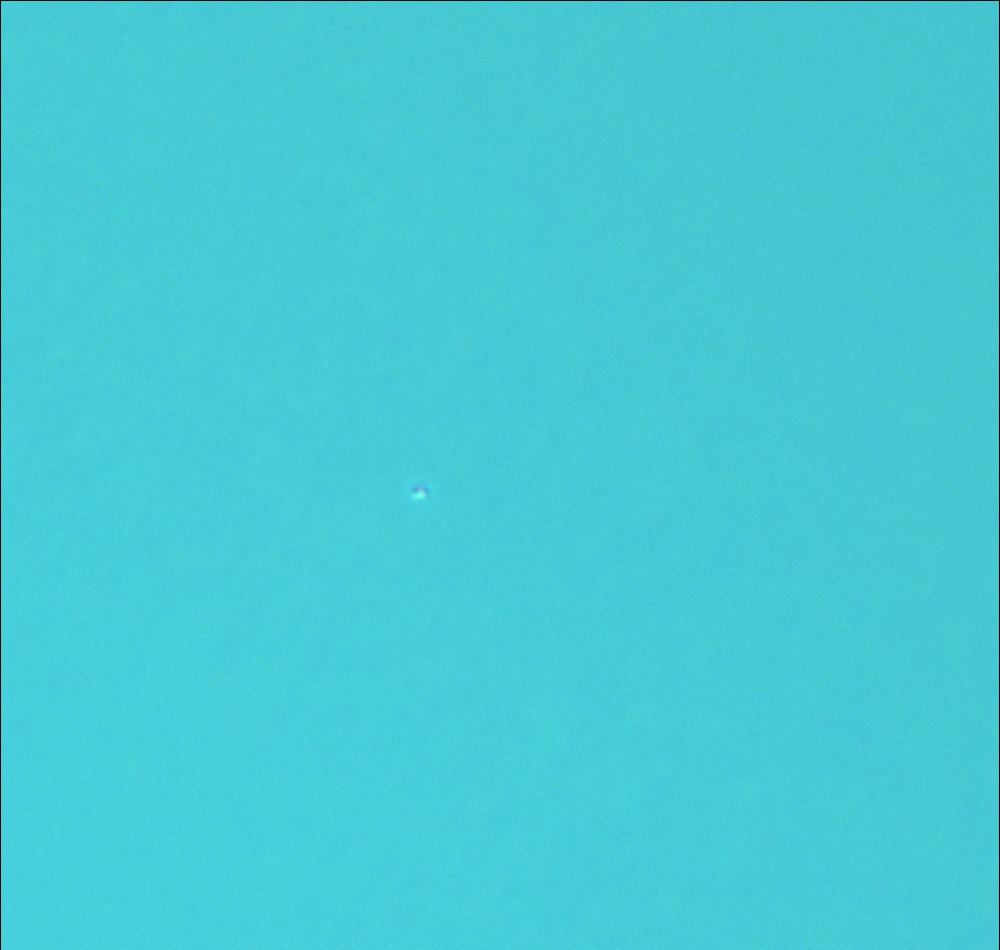

In [2]:
image1 = "image.jpg"
image = Image.open(image1).convert('RGB')
image_size = image.size
print(image_size)
display(image)

In [3]:
def enhance_brightness(image):
    """
    :param image: unenhanced image
    :return: Image with enhanced brightness. The new brightness is within the range of [0.3, 1] if the original brightness is greater than 0.1 else it is set to 0.1
    """
    mean_brightness = get_brightness(image)
    a, b = [0.3, 1]
    if mean_brightness<0.1:
        a = 0.1
    min_, max_ = [0, 1]
    new_brightness = (b - a) * (mean_brightness - min_) / (max_ - min_) + a
        
    brightness_factor = new_brightness/mean_brightness
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(brightness_factor)
    return enhanced_image


def get_brightness(image):
    """
    :param image: unenhanced image
    :return: mean brightness of the image
    """
    brightness = []
    pixel_values = list(image.getdata())
    for values in pixel_values:
        R, G, B = values
        bright = np.sqrt(0.299 * R ** 2 + 0.587 * G ** 2 + 0.114 * B ** 2) / 255
        brightness.append(bright)
    return np.mean(brightness)

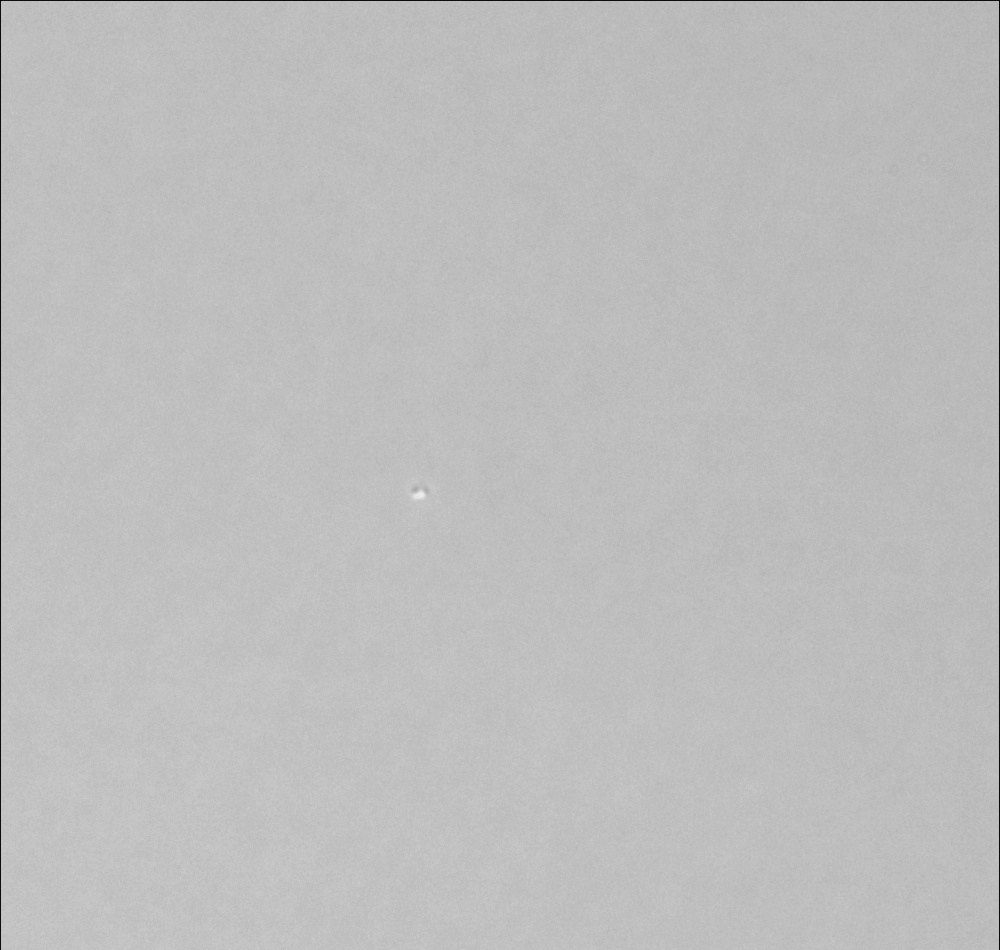

In [4]:
converter = ImageEnhance.Color(image)
image = converter.enhance(0.5) #enchance color by a factor of 0.5
image = enhance_brightness(image)
# convert to grayscale
image = image.convert('L')
display(image)

In [5]:
def get_image_energy(pixels):
    """
    :param pixels: image array
    :return: Energy content of the image
    """
    _, (cH, cV, cD) = dwt2(pixels.T, 'db1')
    energy = (cH ** 2 + cV ** 2 + cD ** 2).sum() / pixels.size
    return energy


def get_energy_density(pixels):
    """
    :param pixels: image array
    :param size: size of the image
    :return: Energy density of the image based on its size
    """
    energy = get_image_energy(pixels)
    energy_density = energy / (pixels.shape[0]*pixels.shape[1])
    return round(energy_density*100,5) # multiplying by 100 because the values are very small

In [6]:
def get_magnitude(response):
    """
    :param response: original gabor response in the form: [real_part, imag_part] 
    :return: the magnitude response for the input gabor response
    """
    magnitude = np.array([np.sqrt(response[0][i][j]**2+response[1][i][j]**2)
                        for i in range(len(response[0])) for j in range(len(response[0][i]))])
    return magnitude

In [7]:
def apply_pca(array):
    """
    :param array: array of shape pXd
    :return: reduced and transformed array of shape dX1
    """
    # apply dimensionality reduction to the input array
    standardized_data = StandardScaler().fit_transform(array)
    pca = PCA(n_components=1)
    pca.fit(standardized_data)
    transformed_data = pca.transform(standardized_data)
    return transformed_data

In [8]:
def applygabor(image1):
    image = Image.open(image1).convert('RGB')
    image_size = image.size
    print(image_size)
    display(image)
    converter = ImageEnhance.Color(image)
    image = converter.enhance(0.5) #enchance color by a factor of 0.5
    image = enhance_brightness(image)
    # convert to grayscale
    image = image.convert('L')
    display(image)
    pixels = np.asarray(image, dtype="int32")
    energy_density = get_energy_density(pixels)
    
    # get fixed bandwidth using energy density
    bandwidth = abs(0.4*energy_density - 0.5)
    magnitude_dict = {}
    for theta in np.arange(0, np.pi, np.pi / 6):
        for freq in np.array([1.4142135623730951, 2.414213562373095, 2.8284271247461903, 3.414213562373095]): 
            filt_real, filt_imag = gabor(image, frequency=freq, bandwidth=bandwidth, theta=theta)
            # get magnitude response
            magnitude = get_magnitude([filt_real, filt_imag])
            ''' uncomment the lines below to visualize each magnitude response '''
            im = Image.fromarray(magnitude.reshape(image_size)).convert('L')
            display(im)
            magnitude_dict[(theta, freq)] = magnitude.reshape(image.size)
        # apply gaussian smoothing
    gabor_mag = []
    for key, values in magnitude_dict.items():
        # the value of sigma is chosen to be half of the applied frequency
        sigma = 0.5*key[1]
        smoothed = gaussian(values, sigma = sigma)
        gabor_mag.append(smoothed)
    gabor_mag = np.array(gabor_mag)

    # reshape so that we can apply PCA
    value = gabor_mag.reshape((-1, image_size[0]*image_size[1]))

    # get dimensionally reduced image
    pcaed = apply_pca(value.T).astype(np.uint8)
    result = pcaed.reshape((image_size[0], image_size[1]))
    result_im = Image.fromarray(result, mode='L')
    display(result_im)

(1000, 950)


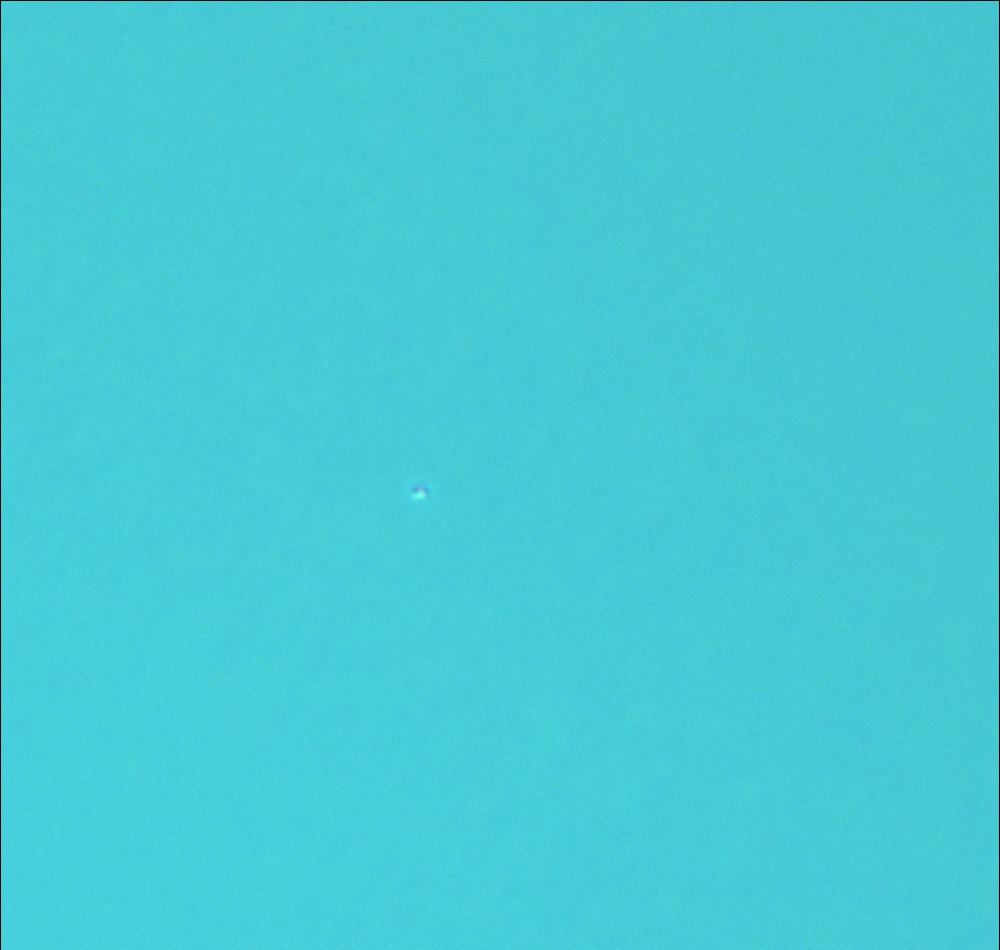

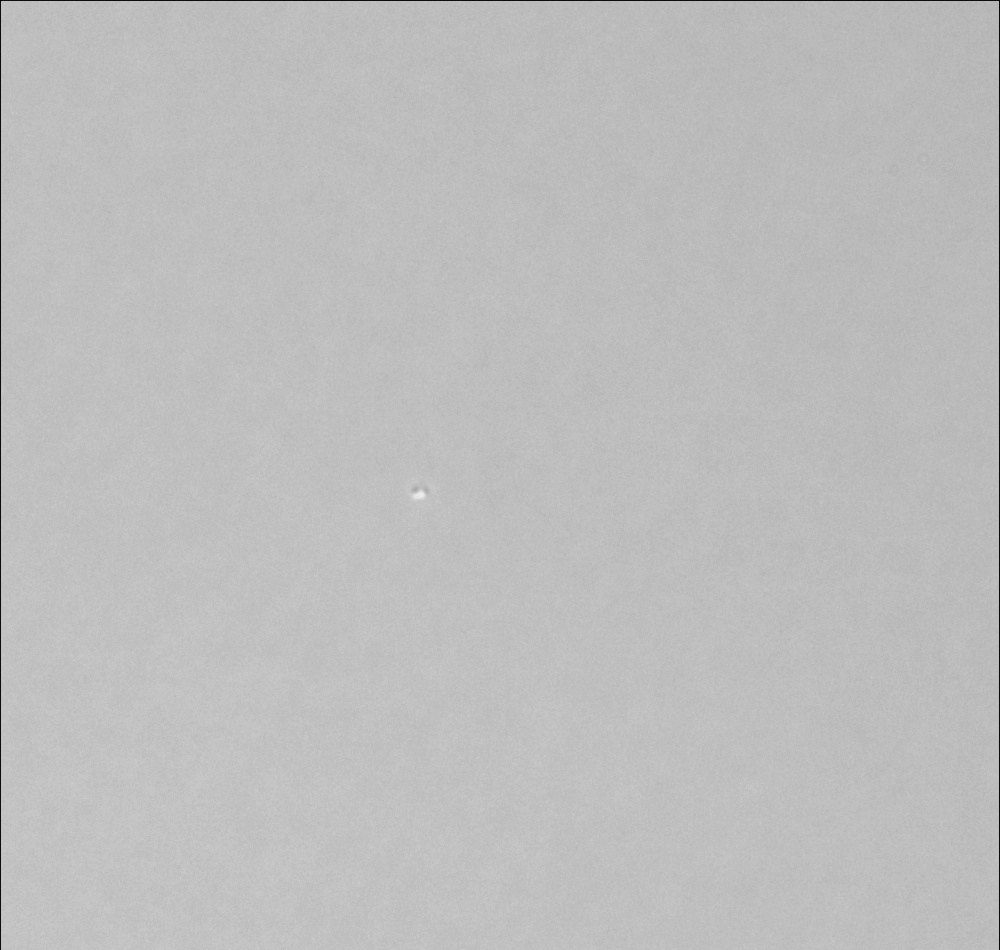

AttributeError: dtype

In [11]:

applygabor("image.jpg")